Имеется набор данных, представляющий собой фотографии с различными видами эмоций, отсортированный по папкам. 



В рамках бизнес-задачи по предсказанию эмоций человека по кадрам с видео (которая описывалась ранее) необходимо предсказывать следующий набор эмоций:
* Счастье (happy)
* Грусть (sad)
* Нейтральность (neutral)
* Удивление (surprised)


Для решения этой задачи будет использован датасет emotion-detection-fet. 


In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt 
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
import warnings

warnings.filterwarnings('ignore')

Проведем анализ имеющихся данных.

# EDA

In [4]:
ROOT_PATH = '../input/dataset/'
train_path = os.path.join(ROOT_PATH, 'train')
test_path = os.path.join(ROOT_PATH, 'test')

### Демонстрация изображений

Text(0.5, 1.0, 'Surprised')

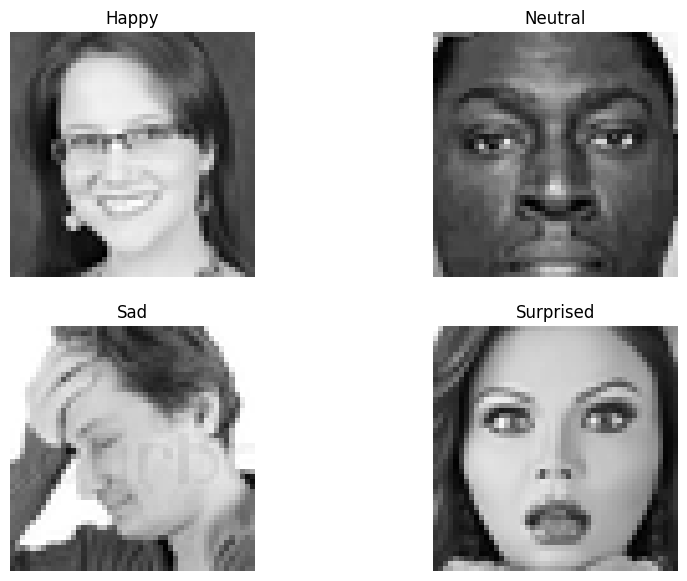

In [5]:
fig = plt.figure(figsize=(10, 7)) 

rows = 2
columns = 2

img_happy = np.asarray(Image.open(os.path.join(train_path, 'happy/im0.png')))
img_neutral = np.asarray(Image.open(os.path.join(train_path, 'neutral/im10.png')))
img_sad = np.asarray(Image.open(os.path.join(train_path, 'sad/im10.png')))
img_surprised = np.asarray(Image.open(os.path.join(train_path, 'surprised/im10.png')))

fig.add_subplot(rows, columns, 1) 
  
plt.imshow(img_happy, cmap="gray") 
plt.axis('off') 
plt.title("Happy") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(img_neutral, cmap="gray") 
plt.axis('off') 
plt.title("Neutral") 
  
fig.add_subplot(rows, columns, 3) 
  
plt.imshow(img_sad, cmap="gray") 
plt.axis('off') 
plt.title("Sad") 
  
fig.add_subplot(rows, columns, 4) 
  
plt.imshow(img_surprised, cmap="gray") 
plt.axis('off') 
plt.title("Surprised") 

### Размерность изображений 

In [6]:
print('Happy -', f'{img_happy.shape}')
print('Sad -', f'{img_sad.shape}')
print('Neutral -', f'{img_neutral.shape}')
print('Surprised -', f'{img_surprised.shape}')

Happy - (48, 48)
Sad - (48, 48)
Neutral - (48, 48)
Surprised - (48, 48)


### Распределение классов

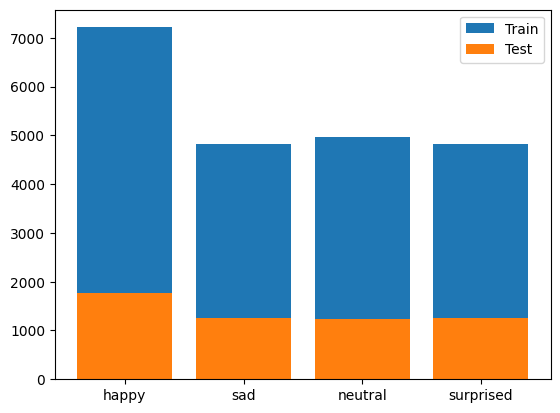

In [7]:
happy_train = len(os.listdir(os.path.join(train_path, 'happy')))
sad_train = len(os.listdir(os.path.join(train_path, 'sad')))
neutral_train = len(os.listdir(os.path.join(train_path, 'neutral')))
surprised_train = len(os.listdir(os.path.join(train_path, 'sad')))

happy_test = len(os.listdir(os.path.join(test_path, 'happy')))
sad_test = len(os.listdir(os.path.join(test_path, 'sad')))
neutral_test = len(os.listdir(os.path.join(test_path, 'neutral')))
surprised_test = len(os.listdir(os.path.join(test_path, 'sad')))


d_train = {'happy' : happy_train, 'sad' : sad_train, 'neutral' : neutral_train, 'surprised' : surprised_train}
d_test = {'happy' : happy_test, 'sad' : sad_test, 'neutral' : neutral_test, 'surprised' : surprised_test}

plt.bar(d_train.keys(), d_train.values(), label='Train')
plt.bar(d_test.keys(), d_test.values(), label= 'Test')
plt.legend();

#### По гистограмме видно, что в тестовой и обучающей выборке класса happy чуть больше чем других.

### Вычислим статистику по изображениям из разных классов



In [8]:
classes = ["happy", "neutral", "sad", "surprised"]
classes_statistics = {class_label: {'mean': None, 'median': None, 'var' : None} for class_label in classes}

for class_image in classes:
    images = os.listdir(os.path.join(train_path, class_image))
    
    images = [np.asarray(Image.open(os.path.join(train_path, class_image, image))) for image in images]
    
    classes_statistics[class_image]['mean'] = np.mean(images)
    classes_statistics[class_image]['median'] = np.median(images)
    classes_statistics[class_image]['var'] = np.var(images)



In [9]:
for i, class_image in enumerate(classes_statistics.items()):
    print("-------")
    print("Класс -",class_image[0])
    for values in class_image[1].items():
        print(values)

-------
Класс - happy
('mean', 129.434760000385)
('median', 134.0)
('var', 4014.1658751719506)
-------
Класс - neutral
('mean', 123.90019022043191)
('median', 126.0)
('var', 4261.861420672666)
-------
Класс - sad
('mean', 121.27496809940764)
('median', 124.0)
('var', 4205.6236626048385)
-------
Класс - surprised
('mean', 146.26256709568486)
('median', 157.0)
('var', 4213.896526689923)


### Получение усредненного лица по классам

#### Для обучающей выборки

In [10]:
images_happy_train = [np.asarray(Image.open(os.path.join(train_path, "happy", img))) for img in os.listdir(os.path.join(train_path, "happy"))]
images_neutral_train = [np.asarray(Image.open(os.path.join(train_path, "neutral", img))) for img in os.listdir(os.path.join(train_path, "neutral"))]
images_sad_train = [np.asarray(Image.open(os.path.join(train_path, "sad", img))) for img in os.listdir(os.path.join(train_path, "sad"))]
images_surprised_train = [np.asarray(Image.open(os.path.join(train_path, "surprised", img))) for img in os.listdir(os.path.join(train_path, "surprised"))]

In [11]:
avg_happy = np.mean(images_happy_train, axis=0)
avg_neutral = np.mean(images_neutral_train, axis=0)
avg_sad = np.mean(images_sad_train, axis=0)
avg_surprised = np.mean(images_surprised_train, axis=0)

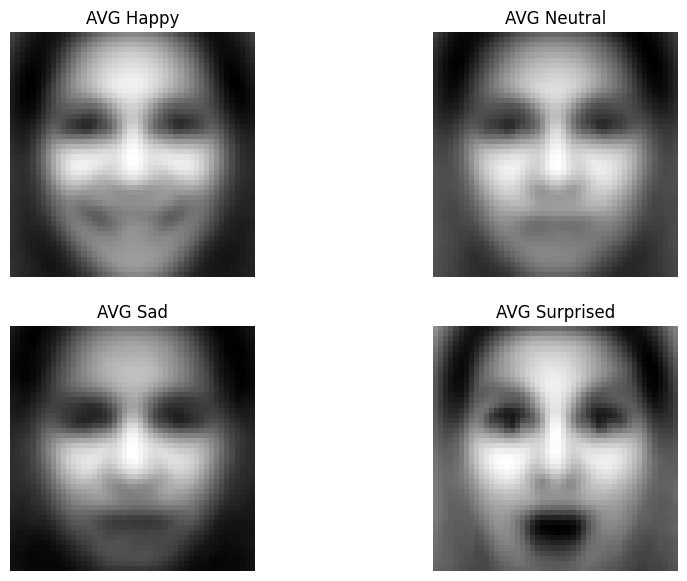

In [12]:
fig = plt.figure(figsize=(10, 7)) 

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1) 
  
plt.imshow(avg_happy, cmap="gray") 
plt.axis('off') 
plt.title("AVG Happy") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(avg_neutral, cmap="gray") 
plt.axis('off') 
plt.title("AVG Neutral") 
  
fig.add_subplot(rows, columns, 3) 
  
plt.imshow(avg_sad, cmap="gray") 
plt.axis('off') 
plt.title("AVG Sad") 
  
fig.add_subplot(rows, columns, 4) 
  
plt.imshow(avg_surprised, cmap="gray") 
plt.axis('off') 
plt.title("AVG Surprised"); 

#### Для тестовой выборки

In [13]:
images_happy_test = [np.asarray(Image.open(os.path.join(test_path, "happy", img))) for img in os.listdir(os.path.join(test_path, "happy"))]
images_neutral_test = [np.asarray(Image.open(os.path.join(test_path, "neutral", img))) for img in os.listdir(os.path.join(test_path, "neutral"))]
images_sad_test = [np.asarray(Image.open(os.path.join(test_path, "sad", img))) for img in os.listdir(os.path.join(test_path, "sad"))]
images_surprised_test = [np.asarray(Image.open(os.path.join(test_path, "surprised", img))) for img in os.listdir(os.path.join(test_path, "surprised"))]

In [14]:
avg_happy= np.mean(images_happy_test, axis=0)
avg_neutral= np.mean(images_neutral_test, axis=0)
avg_sad= np.mean(images_sad_test, axis=0)
avg_surprised= np.mean(images_surprised_test, axis=0)

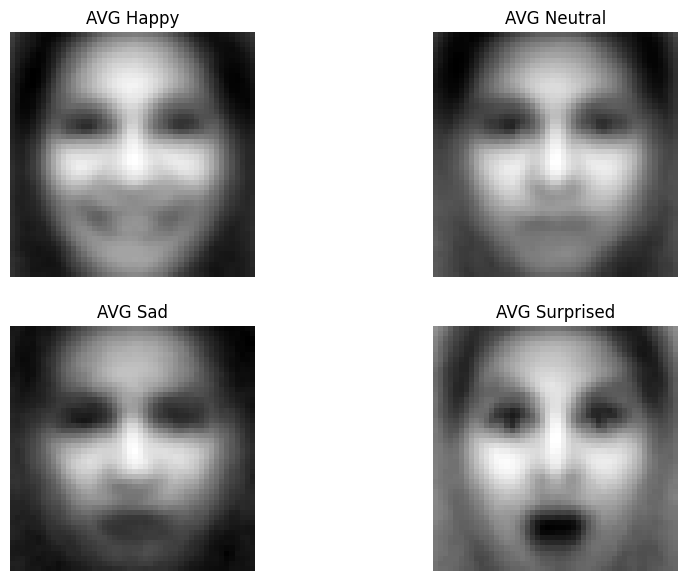

In [15]:
fig = plt.figure(figsize=(10, 7)) 

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1) 
  
plt.imshow(avg_happy, cmap="gray") 
plt.axis('off') 
plt.title("AVG Happy") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(avg_neutral, cmap="gray") 
plt.axis('off') 
plt.title("AVG Neutral") 
  
fig.add_subplot(rows, columns, 3) 
  
plt.imshow(avg_sad, cmap="gray") 
plt.axis('off') 
plt.title("AVG Sad") 
  
fig.add_subplot(rows, columns, 4) 
  
plt.imshow(avg_surprised, cmap="gray") 
plt.axis('off') 
plt.title("AVG Surprised");

### Для всего датасета

In [16]:
happy_dataset = images_happy_train + images_happy_test
sad_dataset = images_sad_train + images_sad_test
neutral_dataset = images_neutral_train + images_neutral_test
surprised_dataset = images_surprised_train + images_surprised_test

In [17]:
avg_happy= np.mean(happy_dataset, axis=0)
avg_neutral= np.mean(neutral_dataset, axis=0)
avg_sad= np.mean(sad_dataset, axis=0)
avg_surprised= np.mean(surprised_dataset, axis=0)

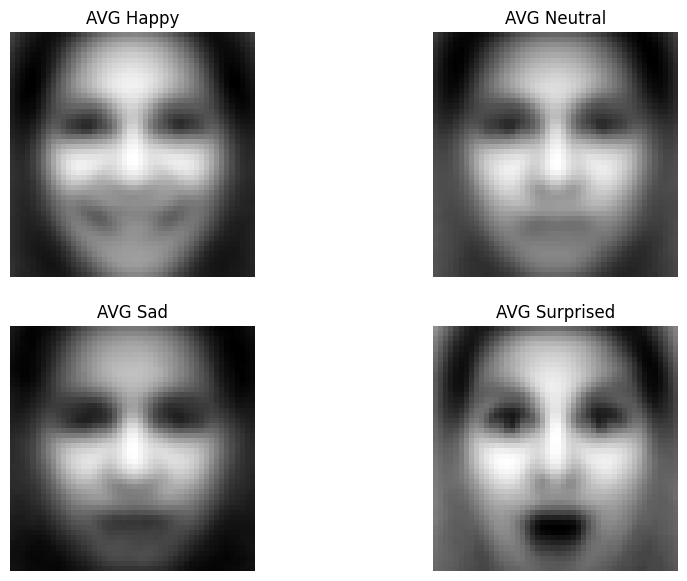

In [18]:
fig = plt.figure(figsize=(10, 7)) 

rows = 2
columns = 2

fig.add_subplot(rows, columns, 1) 
  
plt.imshow(avg_happy, cmap="gray") 
plt.axis('off') 
plt.title("AVG Happy") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(avg_neutral, cmap="gray") 
plt.axis('off') 
plt.title("AVG Neutral") 
  
fig.add_subplot(rows, columns, 3) 
  
plt.imshow(avg_sad, cmap="gray") 
plt.axis('off') 
plt.title("AVG Sad") 
  
fig.add_subplot(rows, columns, 4) 
  
plt.imshow(avg_surprised, cmap="gray") 
plt.axis('off') 
plt.title("AVG Surprised");

По усредненным лицам можно сделать несколько выводов:


    - Изображения с радостым и удивленным выражениями лица заметно отличаются, скорее всего модель будет различать их хорошо;
    
    - Изображения с грустным и нейтральным выражением лица заметно похожи, есть вероятность того, что модель будет их путать. 

## Эмбединги

In [19]:
model = VGG16(weights ='imagenet')

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

2023-12-14 06:44:27.416490: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.416611: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.416738: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.416834: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.416907: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.417115: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-14 06:44:27.417205: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

553467096/553467096 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [20]:
df_feature = pd.DataFrame(columns=[i for i in range(4097)])

In [21]:
classes = ['happy', 'neutral', 'sad', 'surprised']
count = 0
for i, classes in enumerate(classes):
    for image in os.listdir(os.path.join(train_path, classes)):
        image_path = os.path.join(train_path, classes, image)
        
        img = load_img(image_path, target_size=(224,224))
        
        img = img_to_array(img)
        
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        
        img = preprocess_input(img)
        
        feature = model.predict(img, verbose=0)
        
        df_feature.loc[len(df_feature.index)] = np.append(feature, i)
        
        count += 1
        if count == 500:
            break
    count = 0
                            
                            

In [22]:
X = df_feature.drop(4096, axis=1)
Y = df_feature[4096]

### PCA

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [25]:
! pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 31.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [26]:
import plotly.express as px

fig = px.scatter(x=X_pca[:, 0], y=X_pca[:, 1], color=Y)
fig.update_layout(
    title="PCA visualization of Custom Classification dataset",
    xaxis_title="First Principal Component",
    yaxis_title="Second Principal Component",
)
fig.show()

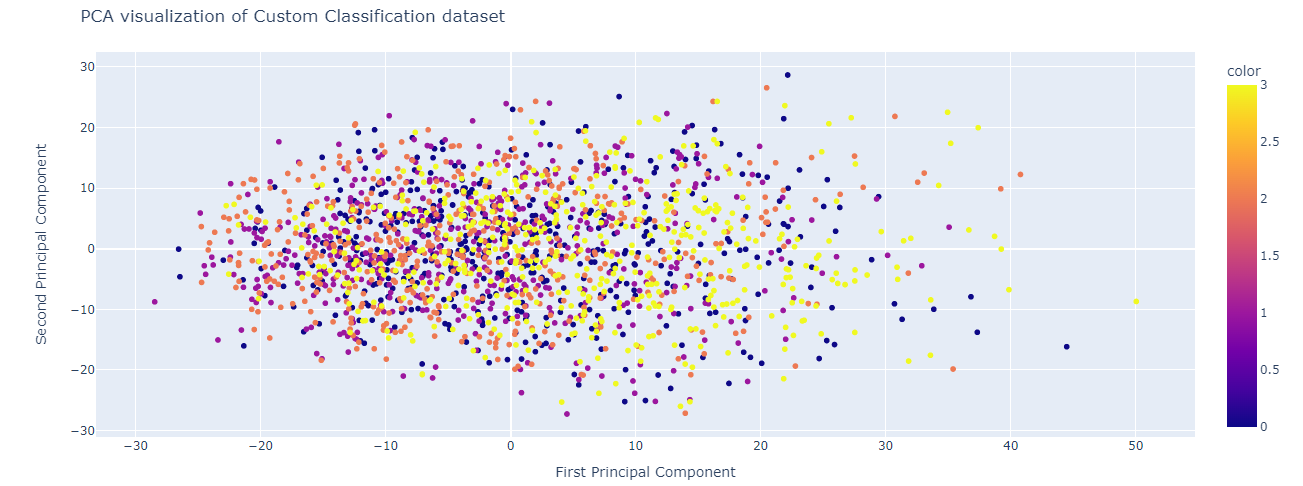

### t-SNE

In [27]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

2.1972124576568604

In [28]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=Y)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

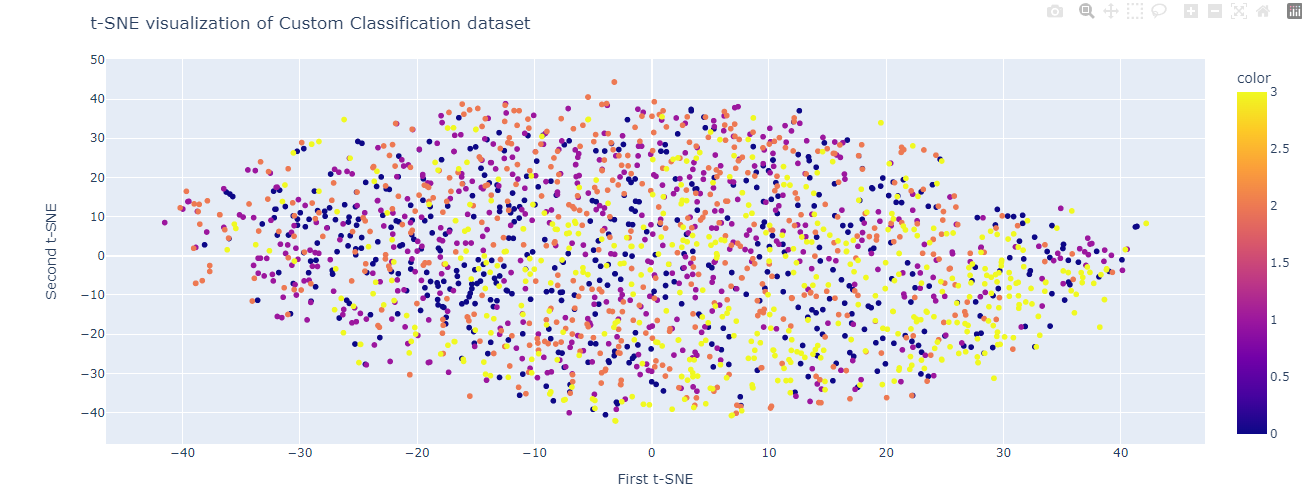

## Попробуем обучить модель на наших данных и посмотреть ембединги

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cpu')

In [31]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.2, 0.2, 0.2])

In [32]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/kaggle/input/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

In [33]:
class_names = image_datasets['train'].classes

print(class_names)

class_to_idx = image_datasets['train'].class_to_idx
print(class_to_idx)

['happy', 'neutral', 'sad', 'surprised']
{'happy': 0, 'neutral': 1, 'sad': 2, 'surprised': 3}


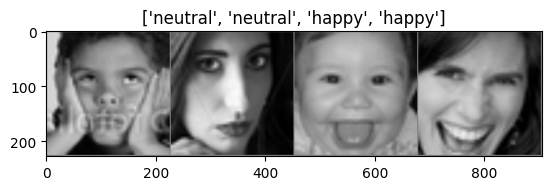

In [34]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Обучение без заморозки весов

In [36]:
model = models.vgg16(pretrained=True)

    
model.classifier[-1] = nn.Linear(in_features=4096, out_features=4)

criterion = nn.CrossEntropyLoss()
optimazer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

step_lr_scheduler = lr_scheduler.StepLR(optimazer, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 176MB/s]  


In [ ]:
model = train_model(model, criterion, optimazer, step_lr_scheduler, num_epochs=10)

In [ ]:
torch.save(model, '/kaggle/working/my_model.pth')

In [ ]:
model.eval()

In [ ]:
model.classifier = model.classifier[:-3]

In [ ]:
my_model = nn.Sequential(*list(model.children()))
my_model

In [ ]:
df_feature = pd.DataFrame(columns=[i for i in range(4097)])

In [ ]:
count = 0
for images, labels in dataloaders["train"]:
    #images = images.to(device)
    outputs = model(images)
    for label, img in zip(labels, outputs):
        df_feature.loc[len(df_feature.index)] = np.append(img.cpu().detach().numpy(), label)
        
        count += 1
    if count % 50 == 0:
        print(count)
    if count > 500:
        break
        

In [ ]:
X = df_feature.drop(4096, axis=1)
Y = df_feature[4096]

### PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
df_pca = pd.DataFrame(X_pca)
df_pca['y'] = Y

plt.scatter(df_pca[df_pca['y'] == 0][0], df_pca[df_pca['y'] == 0][1], label='Happy')
plt.scatter(df_pca[df_pca['y'] == 1][0], df_pca[df_pca['y'] == 1][1], label='Neutral')
plt.scatter(df_pca[df_pca['y'] == 2][0], df_pca[df_pca['y'] == 2][1], label ='Sad')
plt.scatter(df_pca[df_pca['y'] == 3][0], df_pca[df_pca['y'] == 3][1], label='Surprised')

plt.legend()
plt.show()

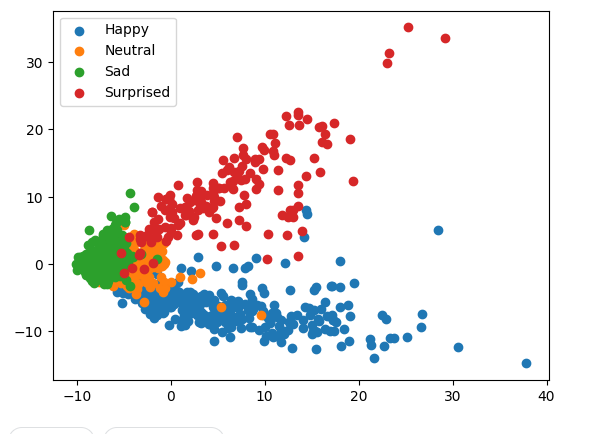

### t-SNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne.kl_divergence_

In [ ]:
df_tsne = pd.DataFrame(X_tsne)
df_tsne['y'] = Y

plt.scatter(df_tsne[df_tsne['y'] == 0][0], df_tsne[df_tsne['y'] == 0][1], label='Happy')
plt.scatter(df_tsne[df_tsne['y'] == 1][0], df_tsne[df_tsne['y'] == 1][1], label='Neutral')
plt.scatter(df_tsne[df_tsne['y'] == 2][0], df_tsne[df_tsne['y'] == 2][1], label ='Sad')
plt.scatter(df_tsne[df_tsne['y'] == 3][0], df_tsne[df_tsne['y'] == 3][1], label='Surprised')

plt.legend()
plt.show()

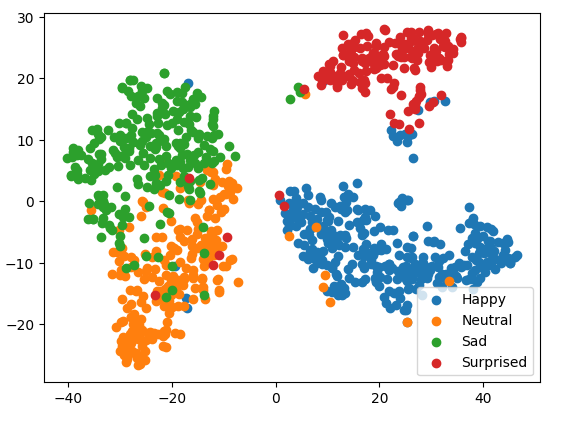

## Facical key point

### Построим усредненное расположение точек для каждой эмоции

In [58]:
df_happy = pd.read_csv('/kaggle/input/key-points/df_happy.csv').drop('Unnamed: 0', axis = 1)
df_sad = pd.read_csv('/kaggle/input/key-points/df_sad.csv').drop('Unnamed: 0', axis = 1)
df_neutral = pd.read_csv('/kaggle/input/key-points/df_neutral.csv').drop('Unnamed: 0', axis = 1)
df_surprised = pd.read_csv('/kaggle/input/key-points/df_surprised.csv').drop('Unnamed: 0', axis = 1)

In [59]:
df_happy['class'] = 'happy'
df_sad['class'] = 'sad'
df_neutral['class'] = 'neutral'
df_surprised['class'] = 'surprised'

In [60]:
# объединяем их по строчно
df = pd.concat([df_happy, df_sad, df_neutral, df_surprised])

In [41]:
df_sad

,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,5_y,...,94_y,95_x,95_y,96_x,96_y,97_x,97_y,98_x,98_y,class
0,7.389755,19.070023,7.843685,21.662445,8.263741,24.158478,8.719810,26.752410,9.079395,29.305390,...,38.896820,24.012756,39.060738,21.322815,39.539948,15.917778,19.144646,33.161774,16.854935,sad
1,14.616093,16.936844,15.328361,18.998920,15.929813,21.424118,16.284672,23.203308,16.715733,25.443466,...,37.271040,26.105560,37.670464,24.837624,37.679910,19.078170,18.427880,32.803978,17.173100,sad
2,7.073540,19.294662,7.806660,21.713379,8.027466,24.512543,8.702362,26.984406,9.513485,29.403840,...,39.504944,25.927605,40.460680,23.043976,40.358032,13.247894,19.796722,30.981445,16.442230,sad
3,0.158806,16.834328,0.820305,19.712067,1.527363,22.386925,2.282169,24.910263,3.109680,27.673874,...,34.926926,26.558739,35.424255,23.572006,35.757446,14.355923,19.097930,31.962479,16.951248,sad
4,5.430683,19.619045,5.732483,22.057587,6.199738,24.756210,6.792458,27.312706,7.422737,29.625153,...,38.915436,26.046783,40.594574,21.736313,40.711870,13.728569,21.419693,34.544990,19.290268,sad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,-5.062115,4.972923,-5.082718,8.659698,-4.535171,12.615272,-4.157654,16.269447,-3.477848,19.637356,...,38.832030,22.641418,39.222397,17.746162,38.799560,9.089355,8.578812,37.596664,8.078423,sad
834,5.411018,15.688881,5.281170,18.347046,5.581848,21.044610,6.312660,23.177444,6.977287,25.292625,...,40.108902,24.929802,40.489470,21.912155,40.010086,14.765049,18.630493,33.500946,19.125763,sad
835,9.266041,14.659660,9.000816,16.898796,8.611755,19.492240,8.280220,21.939247,8.075123,24.226090,...,35.697174,24.196548,35.462837,20.967735,35.165390,17.232307,17.355766,33.178375,19.668450,sad
836,8.945118,21.024513,9.392685,23.113083,9.631592,25.447815,10.126328,27.613953,10.799896,29.691940,...,38.356520,24.334534,39.028305,21.628967,39.052612,13.899734,21.248962,32.093346,17.690807,sad


In [42]:
def rotate_coordinates(coordinates):
    rotated_coordinates = []
    for x, y in coordinates:
        rotated_coordinates.append((-x, -y))
    return rotated_coordinates

def get_mean_points(df):
    columns = df.columns[:-1]
    columns
    columns = df.columns[:-1]
    d = {}
    for i in range(1, 99):
        d[f"{i}_x"] = []
        d[f"{i}_y"] = []


    for index, row in df.iloc[:, :-1].iterrows():
        for i in range(1, 99):
            d[f"{i}_x"].append(np.array(row[f"{i}_x"]))
            d[f"{i}_y"].append(np.array(row[f"{i}_y"]))
            
    for col in columns:
        d[col] = np.mean(d[col])
    
    list_emo = list(d.items())
    
    draw_list = []
    for i in range(0, 196, 2):
        draw_list.append([list_emo[i][1], list_emo[i+1][1]])
    
    draw_list = rotate_coordinates(draw_list)
    
    for x, y in draw_list:
        plt.scatter(x, y)
    
    count = 1
    for x, y in draw_list:
        plt.annotate(f'{count}', (x, y))
        count += 1

## Happy

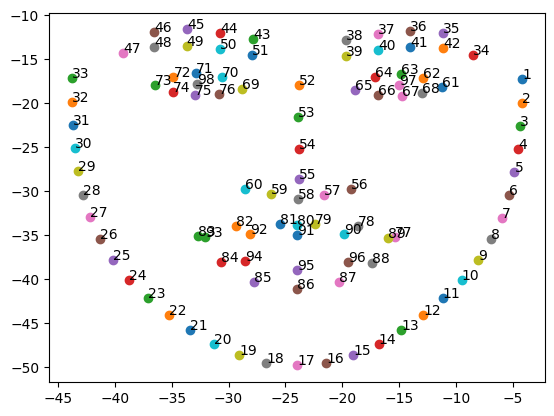

In [43]:
get_mean_points(df[df['class'] == 'happy'])

## Sad

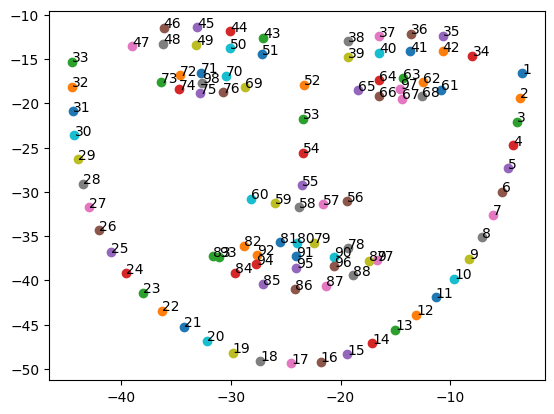

In [44]:
get_mean_points(df[df['class'] == 'sad'])

## Neutral

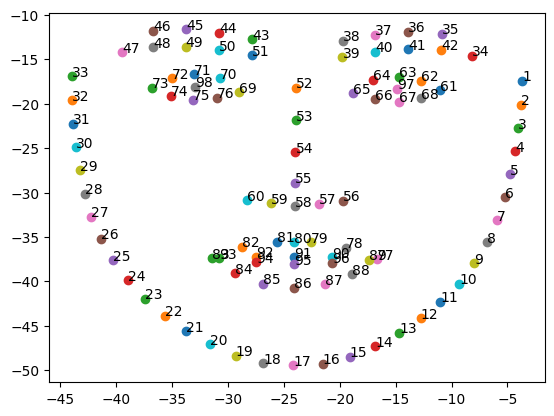

In [45]:
get_mean_points(df[df['class'] == 'neutral'])

## Surprised

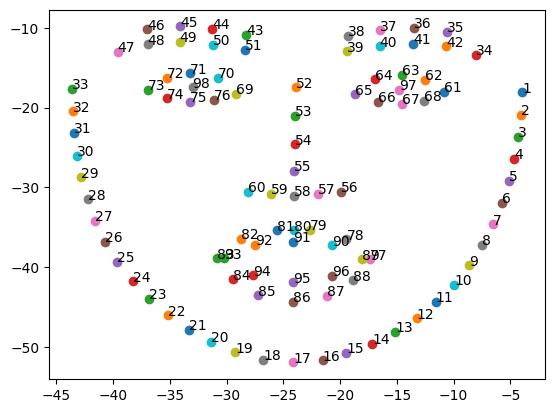

In [46]:
get_mean_points(df[df['class'] == 'surprised'])

# Обучим классификатор и посмотрим на важность признаков

In [47]:
df['class'].replace({'happy' : 0, 'sad' : 1, 'neutral' : 2, 'surprised' : 3}, inplace=True)

In [48]:
rf = RandomForestClassifier()

X = df.drop('class', axis = 1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

rf.fit(X_train, y_train)


RandomForestClassifier()

In [49]:
rf.score(X_test, y_test)

0.6257716049382716

In [50]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [51]:
clf.score(X_test, y_test)

0.7330246913580247

In [52]:
#Creating an XGBoost classifier
model = xgb.XGBClassifier()
#Training the model on the training data
model.fit(X_train, y_train)
#Making predictions on the test set
predictions = model.predict(X_test)
#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6604938271604939


In [53]:
from sklearn.ensemble import GradientBoostingClassifier

# обучение модели
GB = GradientBoostingClassifier()
GB.fit(X_train, y_train)

GradientBoostingClassifier()

In [54]:
GB.score(X_test, y_test)

0.6635802469135802

In [55]:
def get_importances_point(model, lg = False):
    df_feature = pd.DataFrame()
    df_feature['point'] = df.drop('class', axis=1).columns
    
    if lg:
        df_feature['f_imp'] = model.coef_
    else:
        df_feature['f_imp'] = model.feature_importances_
    
    df_feature = df_feature.sort_values('f_imp', ascending=False).head(50)
    
    x_list = []
    y_list = []
    for index, row in df_feature.iterrows():
        if 'y' in row['point']:
            y_list.append(row['point'])
        else:
            x_list.append(row['point'])
    
    points = []
    for x in x_list:
        for y in y_list:
            if x.replace('_x', '') == y.replace('_y', ''):
                points.append(x.replace('_x', ''))
    
    return points

In [56]:
print("RandomForest ", get_importances_point(rf))
print("XGBoost ", get_importances_point(model))
print("GradientBoost", get_importances_point(GB))

RandomForest  ['89', '83', '93', '77', '84', '88', '94', '96']
XGBoost  ['93', '77', '83', '85', '57', '25']
GradientBoost ['93', '83', '77', '89', '88', '94', '53']


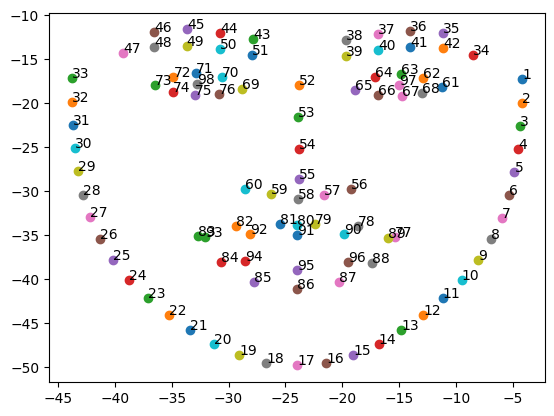

In [61]:
get_mean_points(df[df['class'] == 'happy'])